# Необходимые импорты

In [65]:
import pandas as pd

#линейная регрессия, ridge, lasso
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

#рандомное разделение данных на тестовые и тренировочные
from sklearn.model_selection import train_test_split

#Метод случайного леса
from sklearn.ensemble import RandomForestRegressor

#Gradient Boosting
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#поиск параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#нормализация данных
from sklearn.preprocessing import StandardScaler

import numpy as np
import math

#оценки качества модели
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

#визуализация
import matplotlib.pyplot as plt

#сид для random_state
SEED = 13

# Подготовка данных

In [3]:
df = pd.read_csv("data/laptop_prices.csv")
print(f"Количество элементов в датафрейме: {df.size}")
print(f"Форма датафрейма: {df.shape}")
df.info()
df.nunique()

Количество элементов в датафрейме: 29325
Форма датафрейма: (1275, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1275 non-null   object 
 3   Inches                1275 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Price_euros           1275 non-null   float64
 8   Screen                1275 non-null   object 
 9   ScreenW               1275 non-null   int64  
 10  ScreenH               1275 non-null   int64  
 11  Touchscreen           1275 non-null   object 
 12  IPSpanel              1275 non-null   object 
 13  RetinaDisplay         1275 non-null   object 
 14  CP

Company                  19
Product                 618
TypeName                  6
Inches                   18
Ram                       9
OS                        9
Weight                  171
Price_euros             791
Screen                    4
ScreenW                  13
ScreenH                  10
Touchscreen               2
IPSpanel                  2
RetinaDisplay             2
CPU_company               3
CPU_freq                 25
CPU_model                93
PrimaryStorage           13
SecondaryStorage          6
PrimaryStorageType        4
SecondaryStorageType      4
GPU_company               4
GPU_model               110
dtype: int64

In [4]:
df[['IPSpanel', 'Touchscreen', 'RetinaDisplay']].head()

,IPSpanel,Touchscreen,RetinaDisplay
0,Yes,No,Yes
1,No,No,No
2,No,No,No
3,Yes,No,Yes
4,Yes,No,Yes


In [5]:
#преобразуем object в category для уменьшения размера датафрейма

category_cols = ["TypeName", "OS", "Screen", "CPU_company", "PrimaryStorageType", "SecondaryStorageType", "GPU_company"]

for col in category_cols:
    df[col] = df[col].astype('category')
    
#также, везде, где есть два значения (yes/no), можно преобразовать в булевые столбцы
yes_no_cols =  ['Touchscreen', 'IPSpanel', 'RetinaDisplay']

for col in yes_no_cols:
    df[col] = df[col].map({"Yes" : True, "No" : False}).astype(bool)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Company               1275 non-null   object  
 1   Product               1275 non-null   object  
 2   TypeName              1275 non-null   category
 3   Inches                1275 non-null   float64 
 4   Ram                   1275 non-null   int64   
 5   OS                    1275 non-null   category
 6   Weight                1275 non-null   float64 
 7   Price_euros           1275 non-null   float64 
 8   Screen                1275 non-null   category
 9   ScreenW               1275 non-null   int64   
 10  ScreenH               1275 non-null   int64   
 11  Touchscreen           1275 non-null   bool    
 12  IPSpanel              1275 non-null   bool    
 13  RetinaDisplay         1275 non-null   bool    
 14  CPU_company           1275 non-null   category
 15  CPU_

# Функции для работы с разными моделями регрессий

Цена ноутбука будет предсказываться по нескольким признакам: **объём оперативной памяти, ширина и высота экрана, объём первого и второго хранилищ, диагональ экрана, вес**

- Первая функция делит дату на тренировочную и тестовую, возвращая данные
- Далее модель обучается, возвращая predict_y
- Следующая функция вычисляет оценки качества модели
- Отдельная функция для создания графика
- Последнняя функция комбинирует выше объвленные функции

In [44]:
X = df[['Ram', "ScreenW", "ScreenH", "PrimaryStorage", "SecondaryStorage", "CPU_freq", "Inches", "Weight"]]
Y = df['Price_euros']

def data_split(x=X, y=Y):
    #разделение на тренировочные и тестовые данные
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=SEED)
    
    train_y = np.log(train_y) #логарифмирование цен перед обучением, для снижения влияния крайних значений
    
    return train_x, test_x, train_y, test_y

def model_predict(model, x, y):
    #обучение
    train_x, test_x, train_y, test_y = data_split(x, y)
    model.fit(train_x, train_y)
    predict_y = np.exp(model.predict(test_x)) #предсказание + экспонента
    return test_y, predict_y

def model_errors_metrics(test_y, predict_y, model_name):
    #оценки качества модели
    mae = mean_absolute_error(test_y, predict_y)
    mse = mean_squared_error(test_y, predict_y)
    rmse = root_mean_squared_error(test_y, predict_y)
    r2 = r2_score(test_y, predict_y)

    print(f"Модель: {model_name}")
    print("-------------------")
    print(f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE:{rmse:.2f}\nR2:{r2:.2f}\nРазница между RMSE и MAE: {(rmse - mae):.2f}")
    return mae, mse, rmse, r2

def create_graph(test_y, predict_y, model_name, color, line_type):
    #визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(test_y, predict_y, alpha=0.5, c=color)
    plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], line_type)
    plt.xlabel("Реальные значения")
    plt.ylabel("Предсказанные значения")
    plt.title(f"{model_name}: реальные цены против предсказанных")    
    plt.grid(True)
    
    #сохранение графика модели
    filename = model_name.replace(" ", "_") + ".png" #заменяем название с пробелами на нижние подчёркивания
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
#анализ ошибочных предсказаний, средние характеристики переоценённых/недооценённых ноутбуков
def error_analysis(test_x, test_y, predict_y):
    analysis_df = test_x.copy()
    analysis_df['Real_Price'] = test_y
    analysis_df['Predicted_Price'] = predict_y
    analysis_df['Error'] = abs(test_y - predict_y)

    print("\nТоп-5 ошибочных предсказаний:")
    print(analysis_df.nlargest(5, 'Error')[['Real_Price', 'Predicted_Price', 'Error']])

    print("\nСредние характеристики переоцененных ноутбуков:")
    print(analysis_df[analysis_df['Predicted_Price'] > analysis_df['Real_Price']].mean())
    

#функция полного анализа
def model_analysis(model, model_name, color, line_type, x=X, y=Y):
    #полный анализ модели
    test_y, predict_y = model_predict(model, x, y)
    metrics = model_errors_metrics(test_y, predict_y, model_name)
    create_graph(test_y, predict_y, model_name, color, line_type)
    
    #анализ ошибок
    _, test_x, _, _ = data_split()
    
    error_analysis(test_x, test_y, predict_y)
    
    
    return metrics

# Линейная регрессия

Модель: Линейная регрессия
-------------------
MAE: 378.62
MSE: 370232.21
RMSE:608.47
R2:0.35
Разница между RMSE и MAE: 229.84


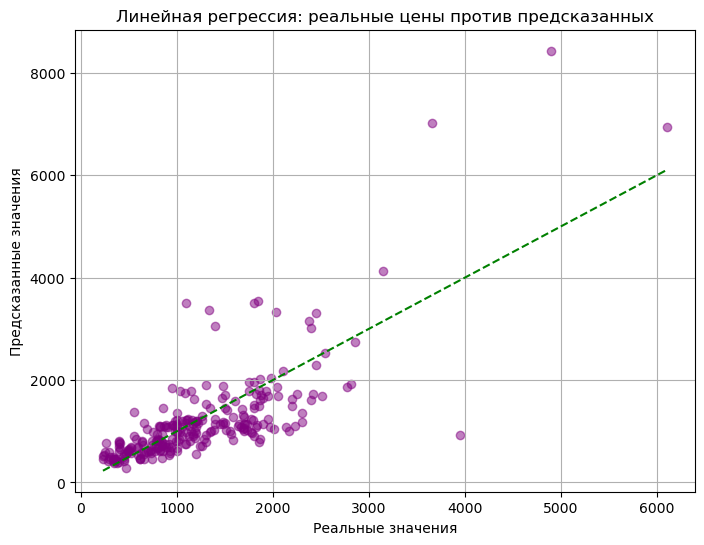


Топ-5 ошибочных предсказаний:
      Real_Price  Predicted_Price        Error
610       4899.0      8427.847064  3528.847064
723       3659.4      7012.040806  3352.640806
1136      3949.4       923.356470  3026.043530
767       1099.0      3503.194940  2404.194940
1068      1329.0      3367.272516  2038.272516

Средние характеристики переоцененных ноутбуков:
Ram                    9.207207
ScreenW             2012.576577
ScreenH             1138.054054
PrimaryStorage       452.756757
SecondaryStorage     175.279279
CPU_freq               2.427027
Inches                15.146847
Weight                 2.059477
Real_Price          1001.007477
Predicted_Price     1385.979310
Error                384.971832
dtype: float64


(378.62259094816994, 370232.21357821516, 608.4671014756798, 0.3476272517682394)

In [45]:
linear_regression = LinearRegression()

model_analysis(linear_regression, "Линейная регрессия", 'purple', 'g--')

### По оценкам метрик можно сделать следующие выводы:

- MAE (средняя абсолютная ошибка) : в целом, модель ошибается на примерно 379 евро
- MSE (средняя квадратичная ошибка): учитывается квадрат ошибок, из-за чего чувствительность к ошибам выше
- RMSE (корень из средней квадратической ошибки): корень из MSE, следовательно резульат в евро. Можно увидеть, что RMSE > MAE на 230 евро, что означает наличие нескольких крупных ошибок, которые совершает модель.
- R2 : означает, что модель работает плохо, всего 35% дисперсий в данных объяснены.

## Ridge / Lasso регрессии

Это два регуляционных метода для линейной регрессии для борьбы с переобучением модели.

Идёт выбор нескольких альфа, из которых RidgeCV и LassoCV выберут самый подходящий вариант из списка с помощью кросс-валидации. Число фолдов кросс-валидации 5

In [46]:
alphas = [0.1, 0.5, 1.0, 1.5, 2, 2.5, 0.05, 0.01, 0.15, 2.25]

Модель: Ridge
-------------------
MAE: 378.68
MSE: 370809.15
RMSE:608.94
R2:0.35
Разница между RMSE и MAE: 230.26


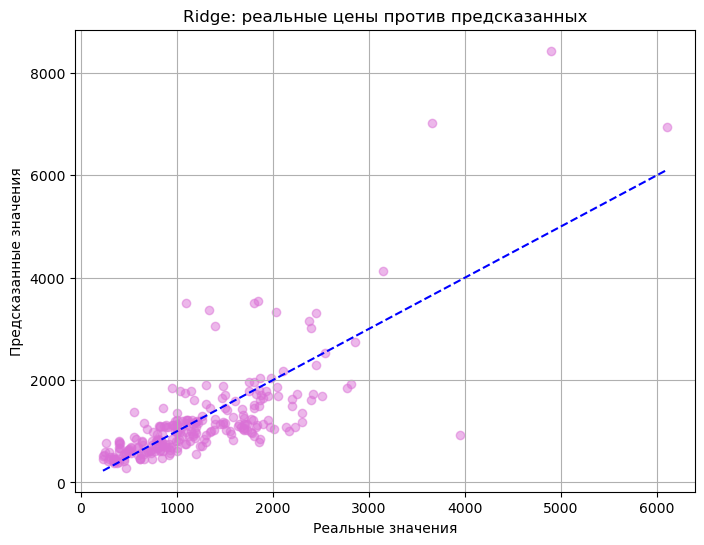


Топ-5 ошибочных предсказаний:
      Real_Price  Predicted_Price        Error
610       4899.0      8429.868960  3530.868960
723       3659.4      7025.828134  3366.428134
1136      3949.4       923.261957  3026.138043
767       1099.0      3505.637374  2406.637374
1068      1329.0      3370.098622  2041.098622

Средние характеристики переоцененных ноутбуков:
Ram                    9.207207
ScreenW             2012.576577
ScreenH             1138.054054
PrimaryStorage       452.756757
SecondaryStorage     175.279279
CPU_freq               2.427027
Inches                15.146847
Weight                 2.059477
Real_Price          1001.007477
Predicted_Price     1385.719456
Error                384.711979
dtype: float64


(378.68133963423463,
 370809.14922162815,
 608.9410063558113,
 0.34661065440733296)

In [47]:
ridge_cv = RidgeCV(alphas = alphas, cv = 5)

model_analysis(ridge_cv, "Ridge", 'orchid', 'b--')

Модель: Lasso
-------------------
MAE: 381.98
MSE: 387410.20
RMSE:622.42
R2:0.32
Разница между RMSE и MAE: 240.44


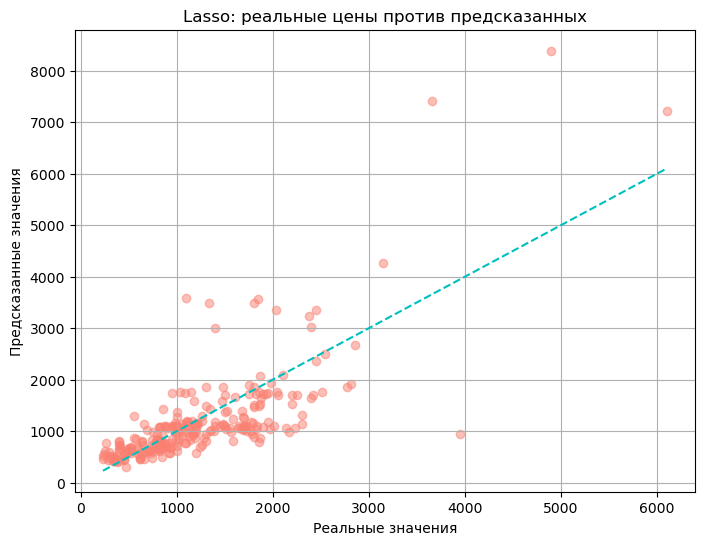


Топ-5 ошибочных предсказаний:
      Real_Price  Predicted_Price        Error
723       3659.4      7414.303576  3754.903576
610       4899.0      8388.355637  3489.355637
1136      3949.4       943.883350  3005.516650
767       1099.0      3587.701456  2488.701456
1068      1329.0      3495.882092  2166.882092

Средние характеристики переоцененных ноутбуков:
Ram                    9.000000
ScreenW             2020.018182
ScreenH             1142.290909
PrimaryStorage       455.709091
SecondaryStorage     176.872727
CPU_freq               2.400000
Inches                15.171818
Weight                 2.073200
Real_Price           975.334818
Predicted_Price     1362.163201
Error                386.828383
dtype: float64


(381.98493376987096, 387410.203852839, 622.4228497194163, 0.31735853847544715)

In [48]:
lasso_cv = LassoCV(alphas = alphas, cv = 5)

model_analysis(lasso_cv, "Lasso", 'salmon', 'c--')

## Elastic-Net

Это дополнительный метод регуляции линейной регресии, который является компромисным вариантом между Lasso и Ridge.

Модель: Elastic Net
-------------------
MAE: 381.26
MSE: 384835.96
RMSE:620.35
R2:0.32
Разница между RMSE и MAE: 239.09


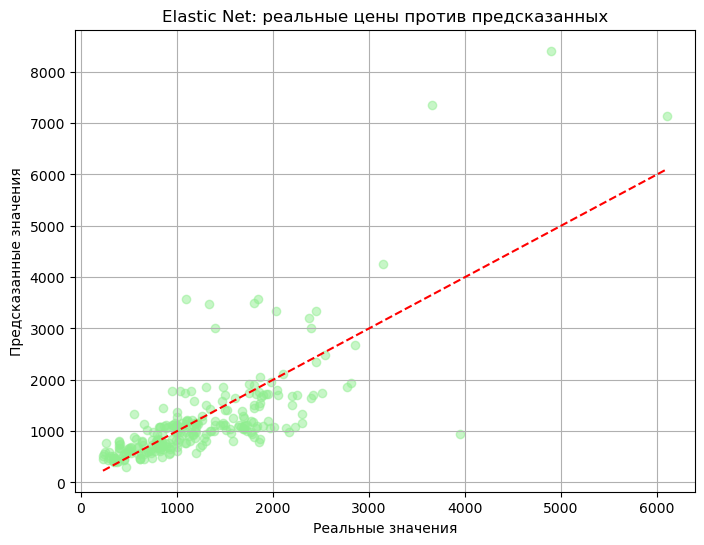


Топ-5 ошибочных предсказаний:
      Real_Price  Predicted_Price        Error
723       3659.4      7354.403899  3695.003899
610       4899.0      8408.741556  3509.741556
1136      3949.4       936.320886  3013.079114
767       1099.0      3570.149977  2471.149977
1068      1329.0      3479.248413  2150.248413

Средние характеристики переоцененных ноутбуков:
Ram                    9.063063
ScreenW             2024.882883
ScreenH             1144.972973
PrimaryStorage       456.216216
SecondaryStorage     175.279279
CPU_freq               2.401802
Inches                15.161261
Weight                 2.064432
Real_Price           985.457928
Predicted_Price     1369.896667
Error                384.438739
dtype: float64


(381.25917452199207, 384835.96422108845, 620.3514844191867, 0.3218945127142676)

In [49]:
elastic_net_cv = ElasticNetCV(alphas = alphas, cv = 5)

model_analysis(elastic_net_cv, "Elastic Net", 'lightgreen', 'r--')

## После применения LassoCV, RidgeCV и ElasticNetCV ожидалось то, что результаты будут сильнее отличаться от линейной регрессии, так как разницы также не было при использовании обычных Lasso, Ridge и Elastic Net

Модели, судя по всему, совершают схожие ошибки

#### Какие возможные причины:
 - Признаки могут быть мало связаны с целевой переменной или сильно кореллированы
 - Датасет, возможно, слишком простой для методов регуляции

Для дальнейшего анализа следует попробовать больше моделей. Возможно, есть зависимости, которые модели выше уловить не могут

# Random Forest Regressor

Модель: Random Forest Regressor
-------------------
MAE: 237.74
MSE: 137716.57
RMSE:371.10
R2:0.76
Разница между RMSE и MAE: 133.36


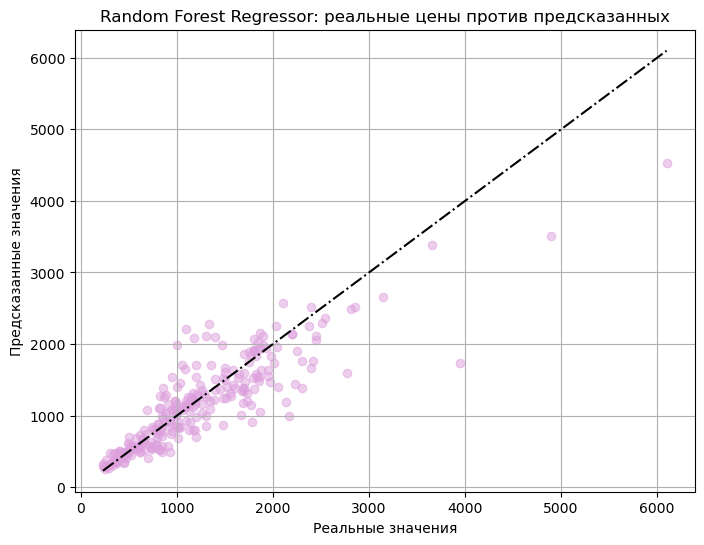


Топ-5 ошибочных предсказаний:
      Real_Price  Predicted_Price        Error
1136     3949.40      1738.774031  2210.625969
196      6099.00      4525.554772  1573.445228
610      4899.00      3509.039924  1389.960076
835      2774.63      1593.869413  1180.760587
1139     2171.72       999.129599  1172.590401

Средние характеристики переоцененных ноутбуков:
Ram                    8.737705
ScreenW             1984.770492
ScreenH             1125.540984
PrimaryStorage       407.377049
SecondaryStorage     218.229508
CPU_freq               2.370492
Inches                15.046721
Weight                 1.972082
Real_Price          1010.270410
Predicted_Price     1189.579562
Error                179.309152
dtype: float64


(237.74150378013908,
 137716.57289412018,
 371.10183628502864,
 0.7573346244842181)

In [50]:
rfr = RandomForestRegressor()

model_analysis(rfr, "Random Forest Regressor", 'plum', 'k-.')

###  Выводы: 
- Значения MAE, MSE, RMSE заметно снизились, а следовательно -- разница между RMSE и MAE. 
- R2 = ~0.76, качество модели выросло и объясняется ~77% дисперсий, что хорошо, в сравнении с прошлыми моделями
- Разница RMSE и MAE стала меньше, модель деляет чуть менее серьёзные ошибки.

#### Значит, RMR лучше объясняет нелинейные зависимости

Также, с помощью RMR можно узнать, какие признаки больше всего влияют на предсказание цены

In [51]:
features = ['Ram', "ScreenW", "ScreenH", "PrimaryStorage", "SecondaryStorage", "CPU_freq", "Inches", "Weight"]

features_df = pd.DataFrame({'feature': features,
                           'importance' : rfr.feature_importances_})

features_df = features_df.sort_values(by="importance", ascending = False)
features_df

,feature,importance
0,Ram,0.595061
5,CPU_freq,0.129926
7,Weight,0.112687
3,PrimaryStorage,0.063669
6,Inches,0.036503
1,ScreenW,0.028218
2,ScreenH,0.027420
4,SecondaryStorage,0.006517


Больше всего на цену из всех использованых признаков влияет количество оперативной памяти. Меньше всего влияет размер вторичного хранилища, возможно, потому что часто его нет.

# Gradient Boosting (XGBoost, LightGBM)

In [52]:
#поиск параметров XGBoost
def find_xgboost(x, y):
    model = XGBRegressor(tree_method='hist', device ='gpu')  #использование гистограмм для ускорения
    params = {'n_estimators': [500, 700, 1000], #количество деревьев
              'max_depth': [3, 5, 7], #максимальная глубина деревьев
              'learning_rate': [0.01], #скорость обучения
              'subsample': [0.8, 1.0] #доля случайных строк для каждого дерева
             }
    
    
    search = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1)
    search.fit(x, y)
    return search.best_params_

train_x, text_x, train_y, text_y = data_split()

best_xgb_params = find_xgboost(train_x, train_y)
print("Самые подходящие параметры для XGBoost:", best_xgb_params)

/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:21] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:21] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:21] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:21] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:21]

/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:22] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:22] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/skl

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:22] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:22] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/skl

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:24] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:24] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/skl

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:26] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:26] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/skl

/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/faust/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Самые подходящие параметры для XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}


Вывод: **Самые подходящие параметры для XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}**

In [41]:
#поиск параметров для LightGBM

def find_lightgbm(x, y):
    model = LGBMRegressor(verbose = -1, boosting_type = 'gbdt')  #скрываем логи
    params = {'n_estimators': [500, 700, 1000],
              'learning_rate': [0.01, 0.05],
              'subsample': [0.8, 1.0],
              'num_leaves': [63, 127],  #максимальное число листьев в дереве
              'min_child_samples' : [10, 20] #защита от переобучения
             }
    
    search = RandomizedSearchCV(model, params, 
                                n_iter = 10, #количество итераций 
                                cv=5, 
                                scoring='neg_mean_squared_error', 
                                n_jobs= 1)
    search.fit(x, y)
    return search.best_params_

best_lgbm_params = find_lightgbm(train_x, train_y)
print("Самые подходящие параметры для LightGBM:", best_lgbm_params)

Самые подходящие параметры для LightGBM: {'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 700, 'min_child_samples': 10, 'learning_rate': 0.01}


Модель: XGBoost
-------------------
MAE: 252.36
MSE: 166395.33
RMSE:407.92
R2:0.71
Разница между RMSE и MAE: 155.55


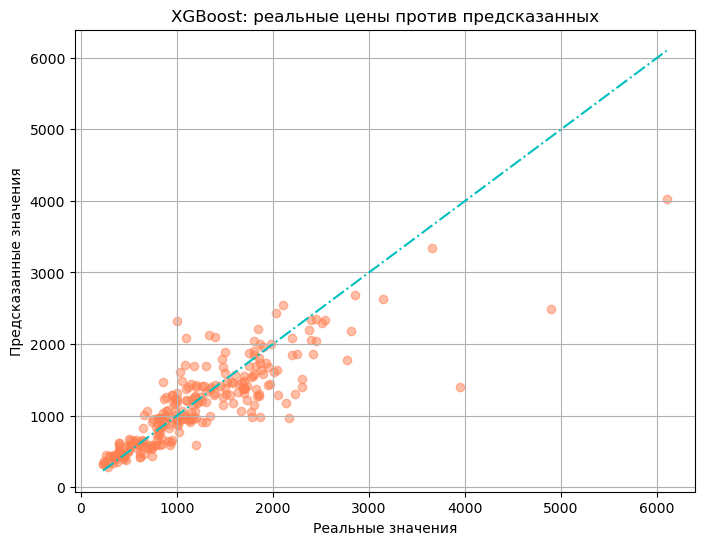


Топ-5 ошибочных предсказаний:
      Real_Price  Predicted_Price        Error
1136     3949.40      1403.025269  2546.374731
610      4899.00      2492.274414  2406.725586
196      6099.00      4031.797607  2067.202393
1061      998.00      2327.569092  1329.569092
1139     2171.72       964.331055  1207.388945

Средние характеристики переоцененных ноутбуков:
Ram                    8.385965
ScreenW             1946.526316
ScreenH             1102.596491
PrimaryStorage       441.894737
SecondaryStorage     161.684211
CPU_freq               2.346491
Inches                15.036842
Weight                 1.987386
Real_Price           896.720702
Predicted_Price     1084.004395
Error                187.283738
dtype: float64


(252.36292987898287, 166395.32589485048, 407.9158318757075, 0.7068008345416155)

In [53]:
xgb = XGBRegressor(learning_rate = 0.01, max_depth = 3, n_estimators = 500, subsample = 0.8)

model_analysis(xgb, "XGBoost", 'coral', 'c-.')

Модель: LightGBM
-------------------
MAE: 252.36
MSE: 166395.33
RMSE:407.92
R2:0.71
Разница между RMSE и MAE: 155.55


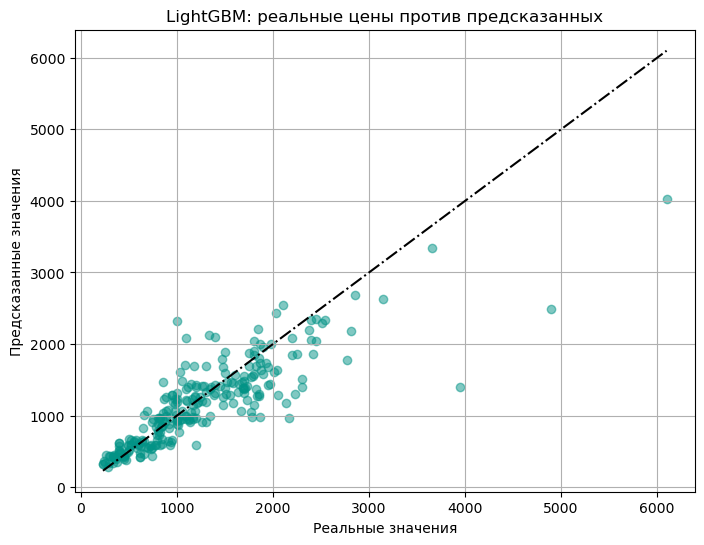


Топ-5 ошибочных предсказаний:
      Real_Price  Predicted_Price        Error
1136     3949.40      1403.025269  2546.374731
610      4899.00      2492.274414  2406.725586
196      6099.00      4031.797607  2067.202393
1061      998.00      2327.569092  1329.569092
1139     2171.72       964.331055  1207.388945

Средние характеристики переоцененных ноутбуков:
Ram                    8.385965
ScreenW             1946.526316
ScreenH             1102.596491
PrimaryStorage       441.894737
SecondaryStorage     161.684211
CPU_freq               2.346491
Inches                15.036842
Weight                 1.987386
Real_Price           896.720702
Predicted_Price     1084.004395
Error                187.283738
dtype: float64


(252.36292987898287, 166395.32589485048, 407.9158318757075, 0.7068008345416155)

In [71]:
lgbm = LGBMRegressor(learning_rate = 0.01, n_estimators = 700, subsample = 1, num_leaves = 127,
                    reg_alpha = 0.1, #l1 регуляция
                    reg_lambda = 0.1, #l2 регуляция)
                    min_child_samples = 10,
                    boosting_type = 'gbdt')

model_analysis(xgb, "LightGBM", 'xkcd:teal', 'k-.')

### Обе модели показали эффективность в ~75%, отставая от RandomForest лишь на ~2%.

## Финальные выводы:

|Метрика| Линйеная регрессия | Ridge | Lasso | Elastic Net | Random Forest | XGBoost | LightGBM |
|:------:|:------------------|:------|:------|:------------|:--------------|:--------|:---------|
| MAE | 378.62 | 378.68 | 381.98 | 312.79 | 237.74 | 252.36 | 252.36 |
| MSE | 370232.21 | 370809.15 | 387410.20 | 384835.96 | 137716.57 | 166395.33 | 166395.33 |
| RMSE | 608.47 | 608.94 | 622.42 | 620.35 | 371.10 | 407.92 | 407.92 |
| R2 | 0.35 | 0.35 | 0.32 | 0.32 | **0.76** | 0.71 | 0.71 |
| RMSE - MAE | 229.84| 230.26 | 240.44 | 239.09 | 133.36 | 155.55 | 155.55 |


- Лучшие показатели у Random Forest Regressor, который устойчив к выбросам.
- Не сильно хуже себя показали XGBoost и LightGBM, возможно, их работу можно улучшить с помощью дополнительного переподбора гиперпараметров
- Линейные модели показали себя хуже всего в одинаковой мере. Это значит, что в данных присутствуют нелинейные зависимости
- Везде заметны достаточно большие выбросы, что говорит о наличии больших выбросов типо слишком дорогих или слишком дешёвых ноутбуков и в целом неравномерном распределении ошибок
- В будущем стоит попробовать учитывать ещё и категориальные данные. Может быть, поможет улучшить качество моделей. Стоит, скорее всего, обратить внимание на "GPU_model" и "CPU_model", так как пользователи часто выбирают устройства именно по этим двум пунктам.
- В исходных данных не учитывается сезонность или акции, возможно, есть неучтённые признаки, которые могут влиять на цену (качество веб-камеры, и т.д)
- Сильнее всего на цену влияет количество RAM, меньше всего - размер дополнительного хранилища


# Предсказание цены ноутбука с помощью Random Forest

In [57]:
def predict_laptop_price(model, ram, screen_w, screen_h, primary_storage, 
                        secondary_storage, cpu_freq, inches, weight, laptop_brand):

    #новый датафрейм с данными ноутбука
    laptop_data = pd.DataFrame({'Ram': [ram],
                                'ScreenW': [screen_w], 'ScreenH': [screen_h],
                                'PrimaryStorage': [primary_storage], 
                                'SecondaryStorage': [secondary_storage],
                                'CPU_freq': [cpu_freq],
                                'Inches': [inches],
                                'Weight': [weight]})
    #предсказание
    predicted_price = model.predict(laptop_data)[0] * 100
    print(f"Предсказанная цена ноутбука {laptop_brand}: {predicted_price:.2f} евро")
    return predicted_price

#средний ноутбук
price1 = predict_laptop_price(rfr, ram=16, 
                             screen_w=1920, screen_h=1080, 
                             primary_storage=512, 
                             secondary_storage=0, 
                             cpu_freq=2.8, inches=15.6, weight=1.8, laptop_brand = "1")
#игровой ноутбук
price2 = predict_laptop_price(rfr, 
                             ram=32, 
                             screen_w=2560, 
                             screen_h=1440, 
                             primary_storage=1000, 
                             secondary_storage=2000, 
                             cpu_freq=3.2, inches=17.3, weight=2.5, laptop_brand="2")

# Ноутбук 3: бюджетный ноутбук
price3 = predict_laptop_price(rfr, ram=8, 
                             screen_w=1366, screen_h=768, 
                             primary_storage=256, secondary_storage=0, 
                             cpu_freq=1.8, inches=14.0, weight=1.5, laptop_brand = "3")

Предсказанная цена ноутбука 1: 759.86 евро
Предсказанная цена ноутбука 2: 803.24 евро
Предсказанная цена ноутбука 3: 693.91 евро


Модель смогла достаточно точно предсказать цены ноутбуков, если сравнивать цены с настоящими на таких сайтах, как Amazon. 
Ранее существовала проблема сильной переоценки, которая была исправлена с помощью логарифмирования.

# Вывод всех графиков сразу для наглядной демонстрации:

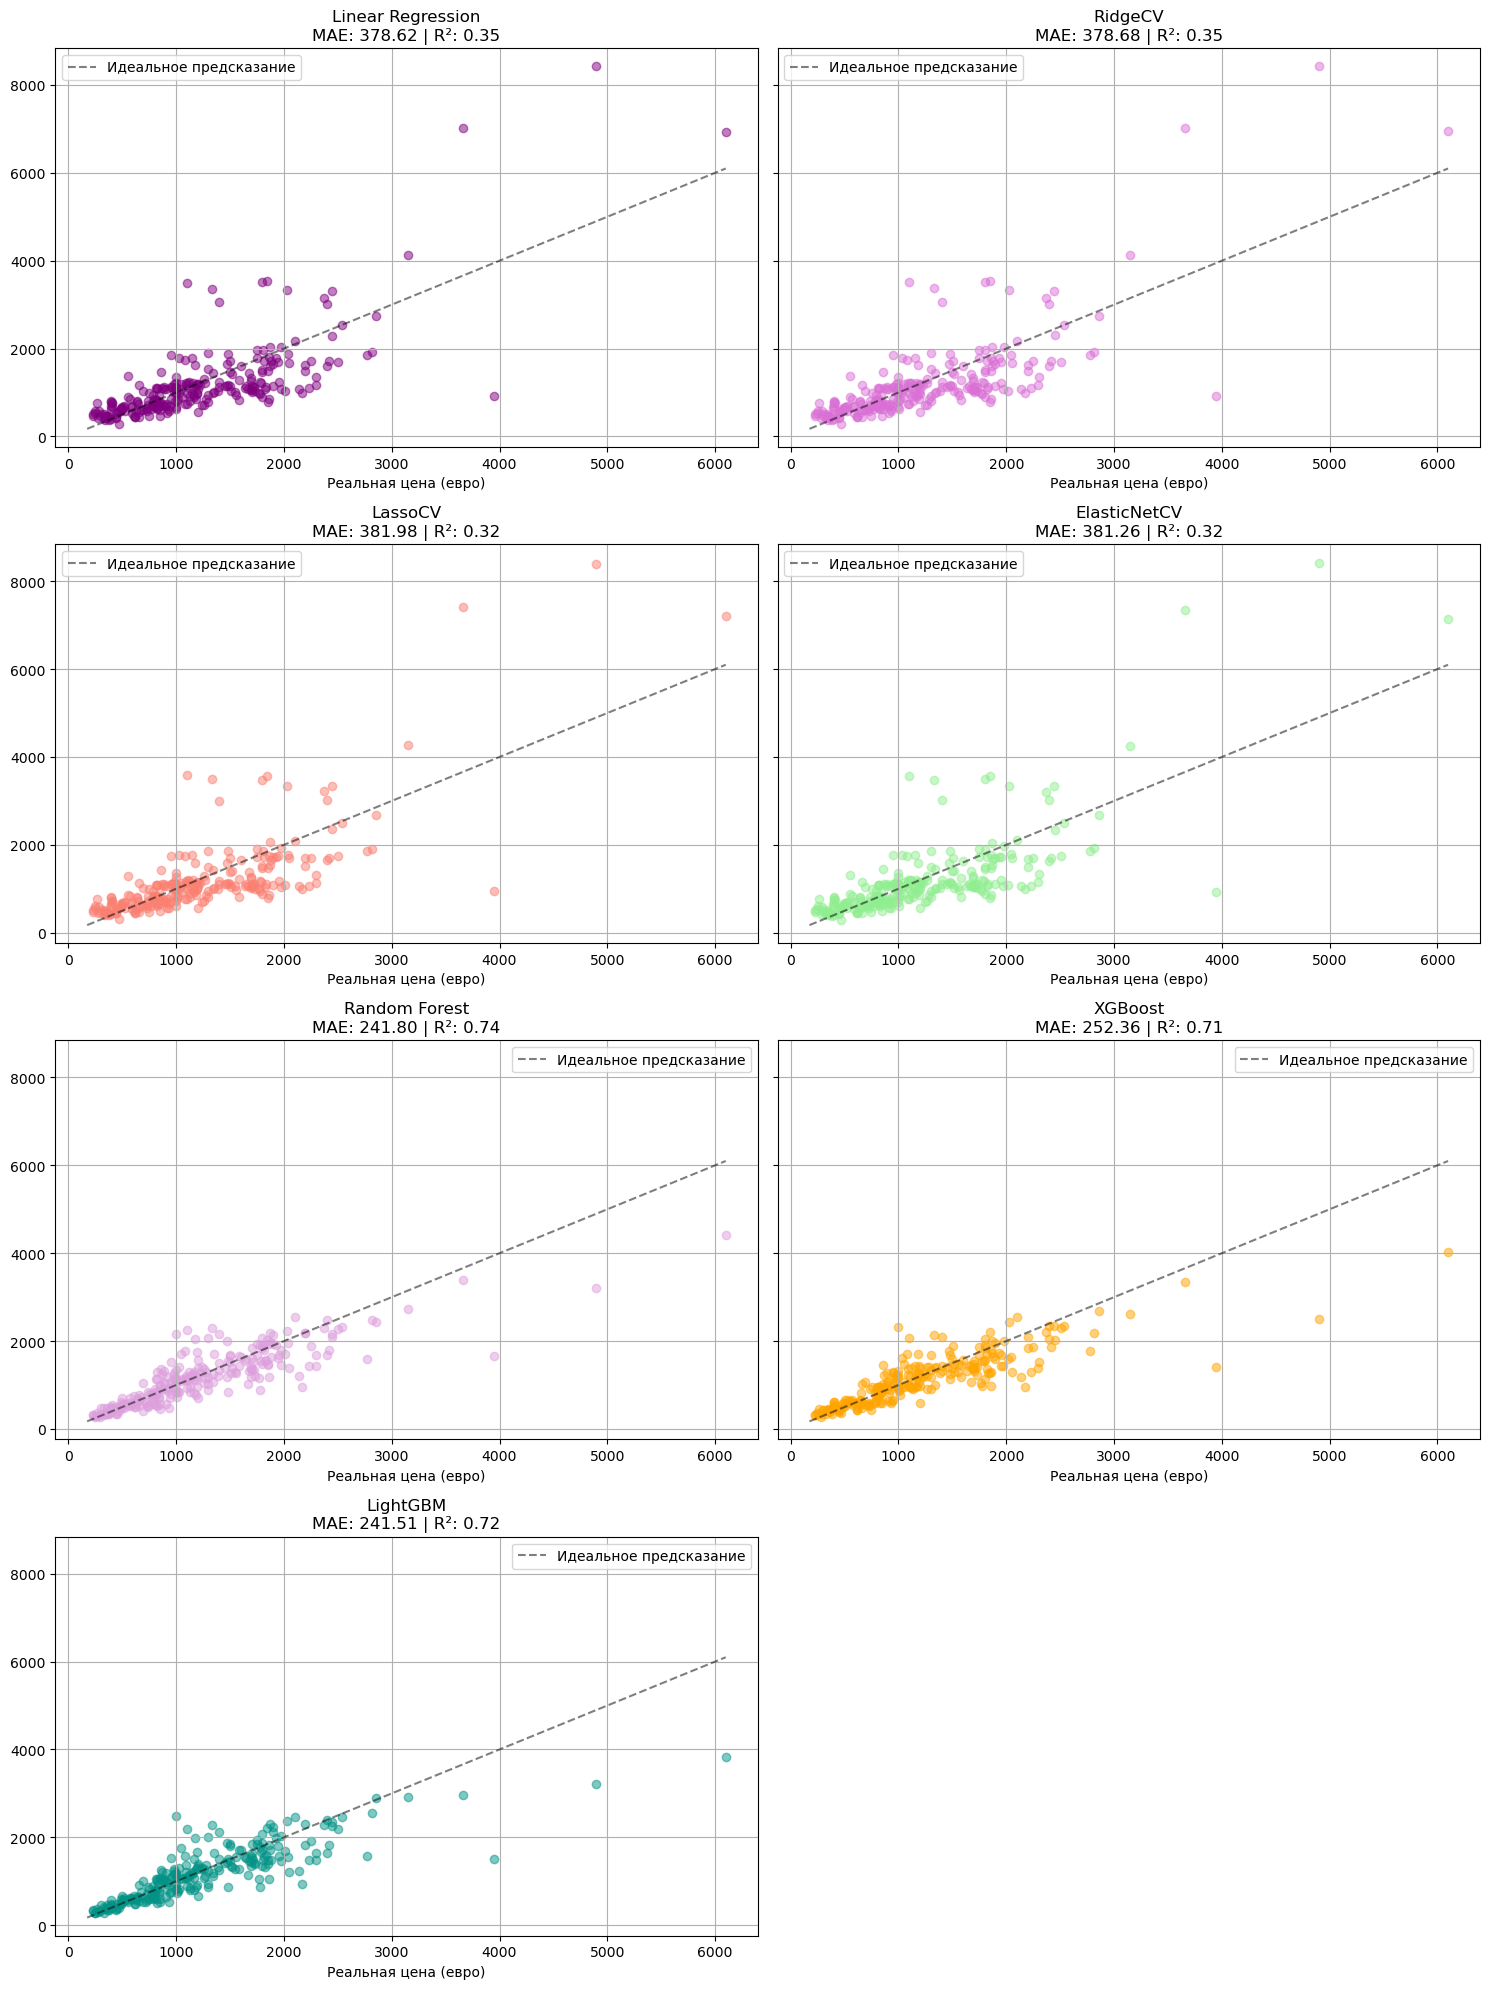

In [70]:
def model_visualize_all(models_dict, x=X, y=Y, figsize=(15, 20), n_cols = 2):
    num_models = len(models_dict)
    n_rows = math.ceil(num_models / n_cols)  #поиск числа строк
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, 
                            squeeze=False,  #возвращение axes как массива
                            sharey=True)    #общая ось у для сравнения
    
    axes = axes.flatten()  #преобразование в плоский массив для удобства
    
    #обход моделей и построение графиков
    for ax, (model_name, (model, color, line_type)) in zip(axes, models_dict.items()):
        test_y, predict_y = model_predict(model, x, y)
        
        ax.scatter(test_y, predict_y, alpha=0.5, c=color)
        
        min_price, max_price = y.min(), y.max()
        ax.plot([min_price, max_price], [min_price, max_price], 
                'k--', alpha=0.5, label="Идеальное предсказание")
        
        #метрики
        mae = mean_absolute_error(test_y, predict_y)
        r2 = r2_score(test_y, predict_y)
        ax.set_title(f"{model_name}\nMAE: {mae:.2f} | R²: {r2:.2f}")
        ax.set_xlabel("Реальная цена (евро)")
        ax.grid(True)
        ax.legend()
    
    #скрытие пустых сабплотов (если моделей не кратно n_cols)
    for i in range(num_models, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig("all_models_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    
models_dict = {
    'Linear Regression': (linear_regression, 'purple', 'g--'),
    'RidgeCV' : (ridge_cv, 'orchid', 'b--'),
    'LassoCV' : (lasso_cv, 'salmon', 'c--'),
    'ElasticNetCV' : (elastic_net_cv, 'lightgreen', 'r--'),
    'Random Forest': (rfr, 'plum', 'k-.'),
    'XGBoost': (xgb, 'orange', 'b-'),
    'LightGBM' : (lgbm, 'xkcd:teal', 'k-.')
}

model_visualize_all(models_dict)